# Project: Teaching an LLM to Reason

In this project, you will teach an LLM to use step-by-step reasoning to answer the question: "How many X's are there in the word Y?"

Counting letters in a word is a surprisingly complex task for an LLM. Just as human beings would not be able to answer such a question for longer words without breaking down the word into its individual letters and then counting them, LLMs cannot be similarly expected to be able to respond without using smaller reasoning steps.

For example, to count the number of o's in the word room, one could use the following reasoning:

```
Question: How many of the letter "o" are there in the word "room"
Answer: 2
Response:

<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
```

In this project we will use the reinforcement learning method GRPO (Group Relative Policy Optimization, of DeepSeek fame) to take a large language model that has been fine-tuned for following instructions and teach it how to break a word down into its letters and then count the requested letter.

We will complete the following steps:

* Set up the notebook
* Create a letter-counting dataset
* Create the reward functions
* Train the model
* View the results

NOTE: This notebook will have you focus on several important aspects of training a GPRO model using LoRA:

1. Configuring LoRA adapters for parameter-efficient fine tuning
2. Selecting reward functions that help the model efficiently find its way to the correct answer (also called reward shaping)
3. Finding hyperparameters that help the model increase the rewards earned more quickly and reliably
4. Learning how to start with smaller experiments and to work your way up to longer experiments.

## Set up the notebook

We'll install dependencies needed for the project, namely `unsloth` and `vllm`, which are useful for fine-tuning LLMs with even just 15GB of VRAM.

In [1]:
# Load ipython-autotime to see how long each cell take to run
# No changes needed in this cell

!pip install -q ipython-autotime
%load_ext autotime

time: 213 μs (started: 2025-12-25 21:38:50 +00:00)


In [2]:
# Verify we have enough GPU memory to run this project (at least 15360MiB)
# No changes needed in this cell

!nvidia-smi

Thu Dec 25 21:38:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   28C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### COMMENTS:

#### lora_rank = 64 was chosen because it is a good middle ground choice between capacity and efficiency. Also becaue we had memory constrains.
#### fast_interface=False.  I try multiple choices and was not able to make this run unless I have it as False.
#### target_modules. Our task will requiere the different roles, the Attention layers and MLP layers. That is, we are giving the model the flexibility to learn what to attend to and how to process and format it.

In [3]:
# Load the `Qwen 2.5 3B Instruct`, and set parameters for the project
# The first time unsloth is imported, it will do its magic and patch the modules
# it works with. This may 2-5 minutes.
# TODO: Fill in the missing parts marked with **********

import unsloth

from unsloth import FastLanguageModel
import torch

max_seq_length = 256  # Increase if you get errors about the sequence length

# Set the LoRA rank to an appropriate value
# Read about setting LoRA rank:
# https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
# lora_rank = **********  # Explain your choice
lora_rank = 64

# Load the Instruct model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # We'll use quantization!
    fast_inference=False,  # Changed from True to False
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.75,  # You can reduce this if you get an memory error
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=[
        # Read about choosing adapters for LoRA:
        # https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
        # Choose the target modules/adapters for your LoRA model
        # ********** # Explain your choice
        # **********
        # **********
        # **********
        # **********
        # **********
        # **********
        'q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'
    ],
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Unsloth enables longer contexts
    # See: https://github.com/unslothai/unsloth
)

/voc/data/venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 12-25 21:39:16 [__init__.py:241] Automatically detected platform cuda.
ERROR 12-25 21:39:18 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.7: Fast Qwen2 patching. Transformers: 4.55.4. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.9.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


time: 57.7 s (started: 2025-12-25 21:38:50 +00:00)


## Try Prompt Engineering to Count Letters

Let's work on the system prompt a little to see if we can get the model to count the number of the letter `g` in `engage`.


Here you must:
* Write clear instructions
* Break the problem down into steps (Chain-of-Thought prompting)
* Provide at least one example for the model to follow (Few-shot prompting)

In [4]:
# First, let's see what happens when we have a blank system prompt
# No changes needed in this cell
SYSTEM_PROMPT = """"""
USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Tokenize the input
inputs = tokenizer([text_for_completion], return_tensors="pt").to("cuda")

# Generate the text completion using standard generate (not fast_generate)
outputs = model.generate(
    **inputs,
    max_new_tokens=2048,
    temperature=0.8,
    top_p=0.95,
    do_sample=True,
)

# Decode the output
output = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)

=== TEXT FOR COMPLETION ===
<|im_start|>system
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
system

user
How many of the letter "g" are there in the word "engage"
assistant
In the word "engage", there is only one letter "g".
time: 3.3 s (started: 2025-12-25 21:39:48 +00:00)


Without any prompting the model will generate an output such as this:

```
=== GENERATED OUTPUT ===
There is one letter "g" in the word "engage".
```

Now let's work on the system prompt to help the model break this problem down into steps, which might help it get the right answer (2 `g`'s in `engage`)

In [5]:
# Let's work on a new system prompt that will help the model break this problem
# down into steps, for example, using "letter-by-letter" spelling.
# TODO: Fill in the missing parts marked with **********

# Use a CoT prompt with at least one example
SYSTEM_PROMPT = """You are a helpful assistant that counts letters in words step-by-step.

To count letters, you should:
1. Break the word down letter by letter
2. Count how many times the target letter appears
3. Provide your reasoning in <reasoning>...</reasoning> tags
4. Provide your final answer in <answer>...</answer> tags

Example:
Question: How many of the letter "o" are there in the word "room"
Answer: 2

Response:
<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
"""

USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

# Tokenize the input
inputs = tokenizer([text_for_completion], return_tensors="pt").to("cuda")

# Generate the text completion using standard generate (not fast_generate)
outputs = model.generate(
    **inputs,
    max_new_tokens=2048,
    temperature=0.8,
    top_p=0.95,
    do_sample=True,
)

# Decode the output
output = tokenizer.decode(outputs[0], skip_special_tokens=True)


# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)
print("=== GENERATED OUTPUT ===")
print(output)

=== TEXT FOR COMPLETION ===
<|im_start|>system
You are a helpful assistant that counts letters in words step-by-step.

To count letters, you should:
1. Break the word down letter by letter
2. Count how many times the target letter appears
3. Provide your reasoning in <reasoning>...</reasoning> tags
4. Provide your final answer in <answer>...</answer> tags

Example:
Question: How many of the letter "o" are there in the word "room"
Answer: 2

Response:
<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
system
You are a helpful assistant that counts letters in words step-by-step.

To count letters, you should:
1. Break the word down letter by letter
2. Count how many times the target letter appea

Did your new prompt get the right answer? Did the model follow all of your instructions?

Maybe yes, maybe no. Either way, we'll want the model to reliably complete this challenge. So let's use GRPO to help it!

## Create a letter-counting dataset

To train a model, we'll first need to create a dataset. We'll use the HuggingFace `datasets` package.

In [6]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]

print(len(ALL_WORDS))

ALL_WORDS[:10]

62


['idea',
 'glow',
 'rust',
 'maze',
 'echo',
 'wisp',
 'veto',
 'lush',
 'gaze',
 'knit']

time: 5.69 ms (started: 2025-12-25 21:40:00 +00:00)


In [7]:
# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

{'words': 'idea', 'letters': 'a', 'counts': 1}

time: 195 ms (started: 2025-12-25 21:40:00 +00:00)


In [8]:
# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

import re
from datasets import load_dataset, Dataset

# Simple CoT prompt (zero-shot)
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

ds = ds.map(
    lambda x: {  # type: ignore
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

ds[0]

{'words': 'idea',
 'letters': 'a',
 'counts': 1,
 'prompt': [{'content': "\nRespond in the following format:\n<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. [first letter] - [count of requested letter so far] so far\n2. [second letter] - [count of requested letter so far] so far\n...\n</reasoning>\n<answer>\n[number]\n</answer>\n",
   'role': 'system'},
  {'content': 'How many of the letter "a" are there in the word "idea"',
   'role': 'user'}]}

time: 14.1 ms (started: 2025-12-25 21:40:00 +00:00)


In [9]:
# Let's see how well the model runs out-of-the-box
# No changes needed in this cell

text = tokenizer.apply_chat_template(
    ds[0]["prompt"], tokenize=False, add_generation_prompt=True
)

# Tokenize the input
inputs = tokenizer([text], return_tensors="pt").to("cuda")

# Generate using standard generate method
outputs = model.generate(
    **inputs,
    max_new_tokens=1024,
    temperature=0.8,
    top_p=0.95,
    do_sample=True,
)

# Decode the output
output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(output)

system

Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>

user
How many of the letter "a" are there in the word "idea"
assistant
<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 1 so far
3. e - 2 so far
4. a - 3 so far
</reasoning>
<answer>
3
</answer>
time: 4.38 s (started: 2025-12-25 21:40:00 +00:00)


## Create Reward Functions

One goal of creating reward functions is to guide the model toward behaviors that help it reach its goal (counting the occurrences of a letter within a word) more easily. Since there is more than one way to carry out any step-by-step task (e.g. whether or not you use bullet points to separate your steps), there's a bit of judgement involved in choosing what behaviors to reward, i.e. how do we provide partial credit or "shape" our rewards?

In this case we will encourage the model to (whether or not this structure is best):
* use numbers for bullet points when spelling out the word
* to spell the word correctly
* to count the requested letter correctly
* to use the requested reasoning format
* to get the final answer correct.


### Numbering reward function

In [10]:
# Let's work on a function that the numbering in the bullet points is correct
# When using GRPO, we lean on reward functions that are relatively easy to
# compute, thus removing the need to have a second large model just for
# evaluation.
# In this case, we'll use regular expressions quite a bit.
# TODO: Fill in the missing parts marked with **********


def extract_letter_numbering(response):
    """Extract the numbers at the beginning of the line

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [1, 2, 3, 4, 5]
    """
    import re

    # We use a regular expression to find lines of the form:
    # '\n[number]. [letter]'
    pattern = r"\n(\d+). [a-z]"

    # Use `re` to find all matches of the pattern in the response
    # matches = **********
    matches = re.findall(pattern, response)
    if matches:
        return [int(m) for m in matches]
    return []


assert extract_letter_numbering(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [1, 2, 3, 4, 5]


def numbering_reward_func(completions, words, **kwargs) -> list[float]:
    """Provides a reward for getting the numbering at the beginning of the line correct

    1. g - 1 so far <-- Good in-order numbering
    2. o - 1 so far <-- Good in-order numbering
    3. a - 2 so far <-- Good in-order numbering
    3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order

    """
    responses = [completion[0]["content"] for completion in completions]

    res = []
    for response, word in zip(responses, words):
        reward = 0

        for ix, spell_number in enumerate(extract_letter_numbering(response)):
            line_number = ix + 1

            # Get points for in-order numbering
            if spell_number == line_number:
                # TODO: Provide a reward for in-order numbering
                # (positive for good behavior, negative for bad)
                # reward += ***********
                reward += 1
            # Otherwise lose points
            else:
                # TODO: Provide a reward for out-of-order numbering
                # (positive for good behavior, negative for bad)
                # reward -= ***********
                reward -= 0.5

            # Lose extra points for continuing beyond the length of the word
            if line_number > len(word):  # We use the index of the line
                # TODO: Provide a reward for continuing beyond the length of the word
                # (positive for good behavior, negative for bad)
                # reward -= ***********
                reward -= 1

        res.append(reward / len(word))
    return res


res = numbering_reward_func(
    completions=[
        [
            {  # Worse response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
</reasoning>
<answer>2</answer>"""
            },
        ],
        [
            {  # Better response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
</reasoning>
<answer>2</answer>"""
            },
        ],
    ],
    words=["goal", "goal"],
)
print(res)

assert res[1] > res[0], "The better response should have a higher reward"

[-0.125, 0.625]
time: 3.57 ms (started: 2025-12-25 21:40:04 +00:00)


### Spelling reward function

In [11]:
# Reward correct spelling of the word
# TODO: Fill in the missing parts marked with **********


def extract_spelling(response):
    """Extract the spelling from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    3. l - 2 so far
    5. l - 2 so far
    Returns "goall"
    """
    import re

    pattern = r"\n\d+\. ([a-z])"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)
    if matches:
        return "".join([m for m in matches])
    return ""


extract_spelling(
    """Here is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
3. l - 2 so far
5. l - 2 so far
"""
) == "goall"


def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """A spelling reward function."""
    from collections import Counter

    responses = [completion[0]["content"] for completion in completions]

    res = []

    for word, response in zip(words, responses):
        reward = 0.0

        # Provide a reward for exactly correct spelling
        # reward += **********
        extracted_spelling = extract_spelling(response)

        if extracted_spelling.lower() == word.lower():
            reward += 10  # Large bonus for perfect spelling

        # Provide a reward for each letter of difference in length
        # reward -= **********
        length_diff = abs(len(extracted_spelling) - len(word))
        reward -= length_diff * 0.05  # Penalty per character difference


        # Provide a reward for each letter that is not in the target word
        # reward -= **********
        word_counter = Counter(word.lower())
        spelling_counter = Counter(extracted_spelling.lower())
        extra_letters = sum((spelling_counter - word_counter).values())
        reward -= extra_letters * 0.1  # Penalty for extra letters

        # Provide a reward for each letter that is in the target word but not in the response
        # reward -= **********
        missing_letters = sum((word_counter - spelling_counter).values())
        reward -= missing_letters * 0.1  # Penalty for missing letters

        res.append(reward)
    return res


res = spelling_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
5. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
        [  # Better Response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
    ],
    words=["goal", "goal"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"

[-0.15000000000000002, 10.0]
time: 38.9 ms (started: 2025-12-25 21:40:04 +00:00)


### Counting reward function

In [12]:
# Let's reward the model for properly counting the occurrences of a letter in a word
# TODO: Fill in the missing parts marked with **********
# No changes needed in this cell, but feel free to experiment with variations on the prompt


def get_resp_letters_and_counts(response):
    """Extract the letters and counts from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [('g', 1), ('o', 1), ('a', 2), ('a', 2), ('l', 2)]
    """
    import re

    pattern = r"\n(\d+)\. ([a-z])\D*(\d+)"

    # Find strings matching e.g. "2. a - 2 so far"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)

    if not matches:
        return []

    return [
        (matched_letter, matched_count_so_far)
        for _, matched_letter, matched_count_so_far in matches
    ]


assert get_resp_letters_and_counts(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [("g", "1"), ("o", "1"), ("a", "2"), ("a", "2"), ("l", "2")]


def counting_reward_func(completions, letters, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]

    res = []

    # Iterate over each of the letter-response pairs
    for letter, response in zip(letters, responses):
        reward = 0

        letters_and_counts = get_resp_letters_and_counts(response)

        # If there are no matches, provide a negative reward
        if not letters_and_counts:
            res.append(-0.5)
            continue

        # Start counting the matching letters
        actual_count = 0
        for resp_letter, resp_count in letters_and_counts:
            # If there's a match, count the letter
            if letter == resp_letter:
                actual_count += 1

            # If the count is accurate, add a reward, else subtract a reward
            # if ... **********
            # else ... **********
                if int(resp_count) == actual_count:
                    reward += 1
                else:
                    reward -= 0.5

        # Return the reward normalized by the length of the matches
        # res.append(**********)
        res.append(reward / len(letters_and_counts))

    return res


res = counting_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 0 so far
2. o - 0 so far
3. a - 1 so far
4. a - 2 so far
5. l - 0 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
        [  # Better response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 1 so far
4. a - 1 so far
5. l - 1 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
    ],
    letters=["g", "g"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.1, 0.2]
time: 61.8 ms (started: 2025-12-25 21:40:04 +00:00)


### Formatting reward functions



In [13]:
# Reward the model for providing the response in a specific format
# TODO: Fill in the missing parts marked with **********


def extract_xml_answer(text: str) -> str:
    """Extracts the string between <answer> and </answer> tags."""
    import re

    pattern = r"<answer>(.*?)</answer>"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    
    return ""

assert (
    extract_xml_answer("""
<reasoning>
This is my reasoning.
</reasoning>
<answer>SUPERCALIFRAGILISTICEXPIALIDOCIOUS</answer>
""")
    == "SUPERCALIFRAGILISTICEXPIALIDOCIOUS"
)


def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"\s*<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"

    res = []

    for completion in completions:
        reward = 0.0

        # Extract the response content
        response = completion[0]["content"]

        # Check if the response matches the pattern
        match = re.match(pattern, response, flags=re.MULTILINE | re.DOTALL)

        # If it matches, return 0.5, otherwise return 0.0
        # if ... **********
        if match:
            reward += 20.0
        # Extract the answer from the response
        # extracted_answer = **********
            extracted_answer = extract_xml_answer(response)
        # If the answer is an integer, add 0.5 to the reward
        # if ... **********
            try:
                int(extracted_answer)
                reward += 5.0
            except ValueError:
                reward -= 0.0
        else:
            reward = 0.0

        res.append(reward)
    return res


res = format_reward_func(
    completions=[
        [{"content": "This is my answer"}],
        [
            {
                "content": "<reasoning>\nThis is my reasoning.\n</reasoning>\n<answer>\n3\n</answer>"
            }
        ],
    ]
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"

[0.0, 25.0]
time: 59.4 ms (started: 2025-12-25 21:40:04 +00:00)


### Task correctness reward function

In [14]:
# Reward the model for providing the correct answer
# TODO: Fill in the missing parts marked with **********


def correct_answer_reward_func(prompts, completions, counts, **kwargs) -> list[float]:
    """Reward the final answer if it is correct."""
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Print a nice summary of the first prompt, answer, and response to see while training
    print(f"""
{"-" * 20}
Question: {prompts[0][-1]["content"]}
Answer: {counts[0]}
Response: {responses[0]}
Extracted: {extracted_responses[0]}
Correct: {str(extracted_responses[0]) == str(counts[0])}!
    """)

    res = [
        # Provide reward for exactly correct answer
        # **********  # Complete the list comprehension
        2.0 if str(r) == str(a) else -0.5
        for r, a in zip(extracted_responses, counts)
    ]
    return res


res = correct_answer_reward_func(
    prompts=[
        [{"content": """How many..."""}],
        [{"content": """How many..."""}],
    ],
    completions=[
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
    ],
    letters=["g", "g"],
    counts=[0, 3],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


--------------------
Question: How many...
Answer: 0
Response: <reasoning>.../reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    
[-0.5, 2.0]
time: 57.1 ms (started: 2025-12-25 21:40:04 +00:00)


### List the reward functions

In [15]:
# List out the reward functions we will use
# No changes needed in this cell

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

time: 56.8 ms (started: 2025-12-25 21:40:04 +00:00)


## Train the model

Now set up GRPO Trainer and configurations!

As you run the trainer, the goal is to see the various `reward` columns increase.

After 50 steps or more, you may notice some of the reward standard deviations begin to decrease, meaning that the different predictions are starting to converge on solutions that give similar rewards. If your model has learned the task, then you'll see the `correct_answer_reward_function` increase to its highest value (check the function to see what that is).

Here is an example, which successfully converged on a higher reward. Note, the values you see here will probably be different from yours, especially if your reward amounts are different.

| Step | Training Loss | reward   | reward_std | ... | kl      | rewards / correct_answer_reward_function / mean | rewards / correct_answer_reward_function / std |
|------|---------------|----------|------------|-----|---------|------------------------------------------|-----------------------------------------|
| 1    | 0.000000      | 7.961805 | 2.368493   | ... | 0.020369| 0.875000                                 | 1.024695                                |
| 2    | 0.000000      | 7.937500 | 1.352467   | ... | 0.016483| 0.875000                                 | 1.024695                                |
| 3    | 0.000000      | 1.894792 | 6.462189   | ... | 0.013677| 0.375000                                 | 0.806226                                |
| ...  | ...           | ...      | ...        | ... | ...     | ...                                      | ...                                     |
| 398  | 0.000100      | 13.000000| 0.000000   | ... | 0.088529| 2.000000                                 | 0.000000                                |
| 399  | 0.000100      | 13.000000| 0.000000   | ... | 0.088617| 2.000000                                 | 0.000000                                |
| 400  | 0.000100      | 13.000000| 0.000000   | ... | 0.096202| 2.000000                                 | 0.000000                                |


In [16]:
# Fill in the GRPO Parameters we'll use throughout this project
# TODO: Fill in the missing parts marked with **********

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Set appropriate values for `learning_rate` and `beta`
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    # See: https://huggingface.co/docs/trl/main/en/grpo_trainer
    learning_rate=5e-5,  # Conservative learning rate for stable training
    beta=0.1,  # KL divergence penalty weight (typical range: 0.01-0.5)
    # Set the batch size appropriately for your hardware. For GRPO there are a number of parameters to set.
    # If you are not sure about your GPU, assume you have a T4. See the memory specs here:
    # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-product-literature/T4%20Product%20Brief.pdf
    per_device_train_batch_size=4,  # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider.
    # Note: Set per_device_train_batch_size to at most 16 on the Vocareum T4 for best stability
    num_generations=4,  # Determines the number of completions/generations to compute for each single prompt
    gradient_accumulation_steps=4,  # This parameter allow us to consider multiple steps in a single optimization step
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs",
    use_vllm=False,  # vll speeds up inference! See https://github.com/vllm-project/vllm
    torch_compile=False,
)

time: 60.5 ms (started: 2025-12-25 21:40:05 +00:00)


### Quick train

Let's train the model for just 5 steps (`max_steps=5`). As it runs we can double check we've set up our prompts correctly before running for a longer amount of time.

In [17]:
# Train for just a few steps for a few minutes
# This will allow us to observe the results and make any changes to our reward functions
# before starting a longer run. Note, you won't see much change in the average.
# reward values
# No changes are needed here

from trl import GRPOConfig, GRPOTrainer

# Short train to check on reward functions
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # We'll just run for a modest 5 steps to make sure everything works and to
    # estimate the amount of time it will take to run the full training.
    max_steps=5,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)
Unsloth: Input IDs of shape torch.Size([16, 262]) with length 262 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 262]) with length 262 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 1 so far
3. i - 1 so far
4. s - 1 so far
5. t - 1 so far
6. e - 1 so far
7. n - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    
Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000300,29.989027,4.267745,91.000000,38.000000,156.000000,0.000000,91.000000,38.000000,156.000000,0.000715,0.903125,0.264870,2.328125,4.576715,0.226525,0.316368,25.000000,0.000000,1.531250,1.007782
2,0.000100,30.390800,3.078007,80.812500,53.000000,112.000000,0.000000,80.812500,53.000000,112.000000,0.000200,0.968750,0.085391,3.531250,5.178896,0.140799,0.138208,25.000000,0.000000,0.750000,1.290995
3,0.000000,30.309671,3.432523,82.937500,39.000000,112.000000,0.000000,82.937500,39.000000,112.000000,0.000111,0.921131,0.215555,3.571875,5.144770,0.222917,0.253929,25.000000,0.000000,0.593750,1.280869
4,-0.000000,30.893402,2.852598,82.000000,71.000000,110.000000,0.000000,82.000000,71.000000,110.000000,0.000048,0.947917,0.079786,4.850000,5.319492,-0.029514,0.113796,25.000000,0.000000,0.125000,1.118034
5,69977792.000000,31.164890,1.795184,91.625000,74.000000,131.000000,0.000000,91.625000,74.000000,131.000000,174944482.000000,1.000000,0.000000,4.178125,5.305122,0.080516,0.163559,25.000000,0.000000,0.906250,1.280869



--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word sapphire
1. s - 0 so far
2. a - 1 so far
3. p - 1 so far
4. a - 2 so far
5. r - 2 so far
6. p - 3 so far
7. h - 3 so far
8. a - 4 so far
9. y - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    

--------------------
Question: How many of the letter "t" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of t's in the word absolve
1. a - 0 so far
2. b - 0 so far
3. s - 1 so far
4. p - 0 so far
5. o - 1 so far
6. l - 1 so far
7. e - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word "mirage"
1. m - 0 so far
2. i - 0 so far
3. r - 0 so far
4. a - 0 so far
5. g - 1 so far
6. e - 1 so far


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


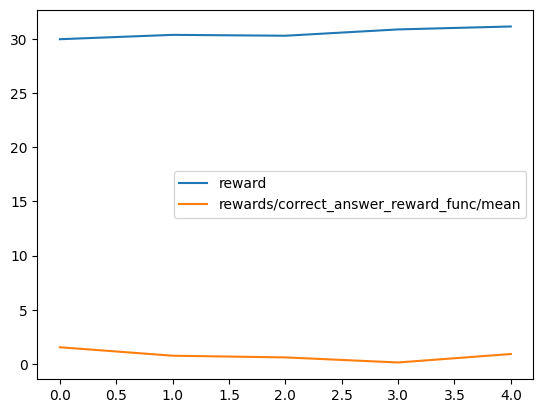

time: 2.12 s (started: 2025-12-25 21:42:39 +00:00)


In [18]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

### Slower train (1+ hour)

If everything looks good, let's go for a longer training session!

In [19]:
# Now let's train for real! Let's do a longer training that will take an hour or more
# Note: If this run is successful, you can consider doing a longer train
# to see what happens, but that's beyond the scope of this project.
# TODO: Fill out the areas where you find **********

# Fix the recompilation limit error
import torch._dynamo
torch._dynamo.config.cache_size_limit = 256  # Increase from default 64
torch._dynamo.config.suppress_errors = True
torch._dynamo.reset()

# Also add this warning suppressor
import warnings
warnings.filterwarnings('ignore')

# Full training
training_args = GRPOConfig(
    **COMMON_GRPO_TRAINING_PARAMS,
    # Configure the maximum number of steps to take about 30mins of time for
    # a medium-sized experiment. (See how long the previous example took and
    # scale up appropriately using your best guess.)
    # max_steps=**********,  # ~60min
    max_steps = 100,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)
Unsloth: Input IDs of shape torch.Size([16, 306]) with length 306 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 306]) with length 306 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 0 so far
3. i - 0 so far
4. s - 0 so far
5. t - 0 so far
6. e - 0 so far
7. n - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,44297196.000000,27.496653,4.973111,95.187500,68.000000,200.000000,0.062500,88.200005,68.000000,156.000000,110742988.000000,0.929688,0.281250,1.734375,4.101452,0.176339,0.117361,23.437500,6.250000,1.218750,1.196784
2,97581280.000000,29.442711,1.018863,86.375000,67.000000,122.000000,0.000000,86.375000,67.000000,122.000000,243953196.000000,1.000000,0.000000,2.243750,4.631230,0.136458,0.081699,25.000000,0.000000,1.062500,1.250000
3,179175328.000000,30.569382,1.404429,90.875000,39.000000,115.000000,0.000000,90.875000,39.000000,115.000000,447938286.000000,0.934524,0.211624,3.531250,5.176964,0.197359,0.232874,25.000000,0.000000,0.906250,1.280869
4,63136968.000000,34.352341,0.364711,89.812500,83.000000,118.000000,0.000000,89.812500,83.000000,118.000000,157842410.000000,1.000000,0.000000,7.371875,4.701559,0.074219,0.131094,25.000000,0.000000,0.906250,1.280869
5,83013368.000000,29.874899,1.412509,90.000000,74.000000,122.000000,0.000000,90.000000,74.000000,122.000000,207533402.000000,1.000000,0.000000,2.881250,4.961044,0.087399,0.173253,25.000000,0.000000,0.906250,1.280869
6,143895456.000000,27.809090,2.747298,86.812500,67.000000,114.000000,0.000000,86.812500,67.000000,114.000000,359738612.000000,0.968750,0.125000,1.090625,3.478373,0.155965,0.170259,25.000000,0.000000,0.593750,1.280869
7,78071680.000000,26.472347,0.977521,86.187500,74.000000,111.000000,0.000000,86.187500,74.000000,111.000000,195179189.500000,0.964286,0.063888,-0.200000,0.106458,0.114311,0.085906,25.000000,0.000000,0.593750,1.280869
8,42955608.000000,26.641157,1.114080,102.000000,71.000000,160.000000,0.000000,102.000000,71.000000,160.000000,107389019.000000,0.982143,0.048795,-0.300000,0.250998,0.052764,0.110784,25.000000,0.000000,0.906250,1.280869
9,158416976.000000,26.673376,0.873221,88.437500,39.000000,122.000000,0.000000,88.437500,39.000000,122.000000,396042418.000000,0.886905,0.283390,-0.334375,0.225624,0.214596,0.340765,25.000000,0.000000,0.906250,1.280869
10,91246896.000000,30.475149,3.353719,83.125000,74.000000,94.000000,0.000000,83.125000,74.000000,94.000000,228117236.000000,1.000000,0.000000,2.990625,4.881742,0.109524,0.117237,25.000000,0.000000,1.375000,1.118034



--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word "sapphire"
1. s - 0 so far
2. a - 0 so far
3. p - 0 so far
4. a - 0 so far
5. a - 0 so far
6. p - 0 so far
7. h - 0 so far
8. a - 0 so far
9. y - 0 so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: False!
    

--------------------
Question: How many of the letter "t" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of t's in the word absolve
1. a - 0 so far
2. b - 0 so far
3. s - 0 so far
4. a - 1 so far
5. b - 1 so far
6. o - 1 so far
7. v - 1 so far
8. e - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word mirage
1. m - 0 so far
2. i - 0 so far
3. r - 0 so far
4. a - 0 so far
5. g - 1 so far


Unsloth: Input IDs of shape torch.Size([16, 266]) with length 266 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 266]) with length 266 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "i" are there in the word "eclipse"
Answer: 1
Response: <reasoning>
Counting the number of i's in the word eclipse
1. e - 0 so far
2. p - 0 so far
3. l - 0 so far
4. c - 0 so far
5. l - 0 so far
6. e - 0 so far
7. i - 1 so far
8. s - 0 so far
9. e - 1 so far
10. a - 0 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "e" are there in the word "echo"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word echo
1. e - 1 so far
2. c - 0 so far
3. h - 0 so far
4. o - 0 so far
5. c - 0 so far
6. e - 1 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "d" are there in the word "void"
Answer: 1
Response: <reasoning>
Counting the number of d's in the word void
1. v - 0 so far
2. o - 0 so far
3. o - 0 so far
4. i - 0 so far
5. d - 1 so far
</reasoning>
<answer>
1
</ans

Unsloth: Input IDs of shape torch.Size([16, 268]) with length 268 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 268]) with length 268 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "p" are there in the word "aperture"
Answer: 1
Response: <reasoning>
Counting the number of p's in the word "aperture"
1. a - 0 so far
2. p - 1 so far
3. p - 1 (already counted) so far
4. t - 1 so far
5. e - 1 so far
6. r - 1 so far
7. p - 1 (already counted) so far
8. e - 1 so far
9. u - 1 so far
10. r - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "m" are there in the word "fume"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. f - 0 so far
2. u - 0 so far
3. m - 1 so far
4. e - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "c" are there in the word "crave"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. c - 1 so far
2. r - 0 so far
3. a - 0 so far
4. v - 0 so far
5.

Unsloth: Input IDs of shape torch.Size([16, 276]) with length 276 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 276]) with length 276 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "a" are there in the word "mantle"
Answer: 1
Response: <reasoning>
Counting the number of a's in the word mantle
1. m - 0 so far
2. a - 1 so far
3. n - 1 so far
4. a - 2 so far
5. t - 2 so far
6. l - 2 so far
7. e - 2 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "i" are there in the word "whistle"
Answer: 1
Response: <reasoning>
Counting the number of i's in the word whistle
1. w - 0 so far
2. h - 0 so far
3. w - 0 so far
4. i - 0 so far
5. s - 0 so far
6. h - 0 so far
7. l - 0 so far
8. e - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Unsloth: Input IDs of shape torch.Size([16, 281]) with length 281 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 281]) with length 281 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "y" are there in the word "torrent"
Answer: 0
Response: <reasoning>
Counting the number of y's in the word torrent
1. t - 0 so far
2. o - 0 so far
3. r - 0 so far
4. r - 0 so far
5. o - 0 so far
6. n - 0 so far
7. e - 0 so far
8. t - 0 so far
9. o - 0 so far
10. y - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: False!
    

--------------------
Question: How many of the letter "w" are there in the word "brawn"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. b - 0 so far
2. r - 0 so far
3. w - 0 so far
4. n - 0 so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: False!
    

--------------------
Question: How many of the letter "m" are there in the word "fathom"
Answer: 1
Response: <reasoning>
Counting the number of m's in the word fathom
1. m - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How

Unsloth: Input IDs of shape torch.Size([16, 271]) with length 271 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 271]) with length 271 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "x" are there in the word "maze"
Answer: 0
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. m - 0 so far
2. a - 1 so far
3. z - 0 so far
4. e - 1 so far
There are no 'x' in the word "maze".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "t" are there in the word "onset"
Answer: 1
Response: <reasoning>
Counting the number of t's in the word onset
1. o - 0 so far
2. n - 0 so far
3. s - 0 so far
4. e - 0 so far
5. s - 1 so far
6. t - 1 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "o" are there in the word "veto"
Answer: 1
Response: <reasoning>
Counting the number of o's in the word veto
1. v - 0 so far
2. e - 0 so far
3. t - 0 so far
4. o - 1 so far
5. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------

Unsloth: Input IDs of shape torch.Size([16, 260]) with length 260 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 260]) with length 260 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "n" are there in the word "torrent"
Answer: 1
Response: <reasoning>
Counting the number of n's in the word "torrent"
1. t - 0 so far
2. o - 0 so far
3. r - 0 so far
4. o - 0 so far
5. t - 0 so far
6. a - 0 so far
7. n - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Unsloth: Input IDs of shape torch.Size([16, 307]) with length 307 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 307]) with length 307 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "e" are there in the word "whistle"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word whistle
1. w - 0 so far
2. h - 0 so far
魔女 - 0 so far
4. s - 0 so far
5. h - 0 so far
6. i - 0 so far
7. l - 0 so far
8. t - 0 so far
9. t - 0 so far
10. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "k" are there in the word "resolve"
Answer: 0
Response: <reasoning>
Counting the number of k's in the word resolve:
1. l - 0 so far
2. o - 0 so far
3. v - 0 so far
4. e - 0 so far
5. s - 0 so far
6. k - 1 so far
7. e - 1 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "i" are there in the word "mirage"
Answer: 1
Response: <reasoning>
1. m - 0 so far
2. i - 1 so far
3. r - 0 so far
4. a - 0 so far
5. g - 0 so far
6. e - 0 so far
The letter "i" appears one time in 

Unsloth: Input IDs of shape torch.Size([16, 282]) with length 282 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 282]) with length 282 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "i" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
1. s - 0 so far
2. a - 0 so far
3. p - 0 so far
4. a - 0 so far
5. p - 0 so far
6. h - 0 so far
7. a - 0 so far
8. p - 1 so far
9. y - 1 so far
10. e - 1 so far

There is 1 letter "i" in the word "sapphire". 
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "t" are there in the word "mantle"
Answer: 1
Response: <reasoning>
Counting the number of t's in the word "mantle":
1. m - 0 so far
2. a - 0 so far
格子
3. n - 0 so far
4. t - 1 so far
5. l - 0 so far
6. e - 0 so far
There is only one "t" in the word "mantle".
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "p" are there in the word "sapphire"
Answer: 2
Response: <reasoning>
1. p - 1 so far
2. s - 0 so far
3. a - 2 so far
4. p - 1 so far
5. a - 3 so far
6. p - 2 so far

Unsloth: Input IDs of shape torch.Size([16, 305]) with length 305 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 305]) with length 305 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "i" are there in the word "triumph"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. i - 2 so far
2. i - 2 so far
...
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "s" are there in the word "zealous"
Answer: 1
Response: <reasoning>
Counting the number of s's in the word "zealous":
1. z - 0 so far (no "s" at the beginning)
2. e - 0 so far
3. a - 0 so far
4. l - 0 so far
5. o - 0 so far
6. w - 0 so far
7. s - 1 so far (found one "s")
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "e" are there in the word "verge"
Answer: 2
Response: <reasoning>
1. v - 0 so far
2. e - 1 so far (The first e)
3. r - 0 so far
4. g - 0 so far
5. e - 1 so far (The second e)
3. d - 0 so far
1. Counting the letter "e" in "verge", we find there are 2 "e"s.
</reas

Unsloth: Input IDs of shape torch.Size([16, 296]) with length 296 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 296]) with length 296 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "y" are there in the word "lantern"
Answer: 0
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. l - 0 so far
2. a - 0 so far
3. r - 0 so far
4. t - 0 so far
5. e - 0 so far
6. n - 0 so far
7. y - 0 so far

There are no "y"s in the word "lantern".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "h" are there in the word "fusion"
Answer: 0
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. f - 0 so far
2. u - 0 so far
3. s - 0 so far
4. i - 0 so far
5. o - 0 so far
6. n - 0 so far
7. h - 0 so far
8. h - 1 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "o" are there in the word "onset"
Answer: 1
Response: <reasoning>
1. [o] - [1] so far.
2. [n] - [1] so far.
3. [s] - [1] so far.
4. [e] - [1] so far.
5. [t] - 

Unsloth: Input IDs of shape torch.Size([16, 301]) with length 301 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 301]) with length 301 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "c" are there in the word "wisp"
Answer: 0
Response: <reasoning>
1. The first letter in "wisp" is "w" - 0 occurrences
2. The second letter in "wisp" is "i" - 0 occurrences
3. The third letter in "wisp" is "s" - 0 occurrences
4. The fourth letter in "wisp" is "p" - 0 occurrences

There are 0 occurrences of the letter "c" in the word "wisp".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    


Unsloth: Input IDs of shape torch.Size([16, 291]) with length 291 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 291]) with length 291 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "a" are there in the word "radius"
Answer: 1
Response: <reasoning>
1. r - 0     
2. a - 1
3. d -  convert r: 0 to a: 1, then add one because we see an 'a'. Now a count = 1.
4. a - convert ar: 1 to ad: 1+1 = 2
5. i - convert ad: 2 to is: 2+1 = 3
6. s - convert is: 3 to si: 3+1 = 4
7. a - convert si: 4 to sa: 3+1 = 4
8. s - convert sa: 4 to sa: 3+1 = 4, repeat: add one more. 

So there are [answer] "a"s in "radius". 
</reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    

--------------------
Question: How many of the letter "j" are there in the word "elude"
Answer: 0
Response: <reasoning>
1. First letter: "e" - There are no "j"s.
2. Second letter: "l" - There are no "j"s.
3. Third letter: "u" - There are no "j"s.
4. Fourth letter: "d" - There are no "j"s.
5. Fifth letter: "e" - There are no "j"s.

Thus, there are 0 "j"s in the word "elude".
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

------------

Unsloth: Input IDs of shape torch.Size([16, 294]) with length 294 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 294]) with length 294 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "m" are there in the word "maze"
Answer: 1
Response: Let's count the number of "m"s in the word "maze" step by step.

<reasoning>
1. 'm' - Count of first instance of "m" is 1.
2. 'a' - There is no "m" in the remaining part so far, the count remains 1.
3. 'z' - Here, 'm' is not appearing within this part, the count remains 1.
4. 'e' - Here, 'm' is not appearing within this part, the count remains 1.
</reasoning>
Therefore, the number of letter "m" found in the word "maze" is:
<answer>
1
</answer>

Note that although the letter 'm' appears once in the word "maze," it's important to be thorough in counting through every instance.
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "e" are there in the word "mantle"
Answer: 1
Response: <reasoning>
1. m - Correct, so far 1 instance.
2. n - Correct, so far 2 instances.
3. a - Correct, so far 3 instances.
4. t - Correct, so far 4 instances.
5. t - Corre

Unsloth: Input IDs of shape torch.Size([16, 297]) with length 297 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 297]) with length 297 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "r" are there in the word "crisp"
Answer: 1
Response: <reasoning>
1. c - 0
2. r - 1
3. r - 2
4. i - 3
5. s - 4
6. p - 5
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "t" are there in the word "enchant"
Answer: 1
Response: <reasoning>
To find the number of times the letter "t" appears in the word "enchant", let's count the frequency of it:

1. e - 0
2. n - 0
火焰
3. a - 1
4. n - 0
5. c - 0
6. h - 1
7. t - 0
8. n - 1

So there are 2 letters "t" in "enchant".
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "c" are there in the word "scarab"
Answer: 1
Response: Let me count the number of letter "c"s in the word "scarab".
<reasoning>
1. s - 0 so far
2. c - 1 so far
3. a - 1 so far
4. r - 1 so far
5. a - 2 so far
6. b - 2 so far
</reasoning>
	answer:
2
Extracted: 
Correct: False!
    

-----

Unsloth: Input IDs of shape torch.Size([16, 284]) with length 284 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 284]) with length 284 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "m" are there in the word "mantle"
Answer: 1
Response: <reasoning>
Counting the number of letter "m"s in the word "mantle"
1. m - 1 so far
2. a - 1 so far
3. n - 1 so far
4. t - 1 so far
5. l - 1 so far
6. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "a" are there in the word "grim"
Answer: 0
Response: <reasoning>
Counting the number of a's in the word grim
1. g - 0 a's so far
2. r -  0 a's so far
3. i -  0 a's so far
4. m -  0 a's so far
</reasoning>
<answer>
0
</answer>
Extracted: 0
Correct: True!
    

--------------------
Question: How many of the letter "h" are there in the word "oath"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. o - 0 so far
2. a - 1 so far
3. h - 1 so far
4. e - 0 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Unsloth: Input IDs of shape torch.Size([16, 300]) with length 300 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 300]) with length 300 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "e" are there in the word "aperture"
Answer: 2
Response: Let's count how many "e"s are in the word "aperture" using the given method:

1) a - 0
2) p - ०
3) p - pu (0)
4) e - pdu (5 letters counted so far, 1 is counted: e)
5) r - pu (1 e, 7 letters counted)
6) u - pu (1 e, 7 letters counted)
7) t - u (1 e, 8 letters counted, 1 is counted)
8) e - t (1 e, 9 letters counted, 1 is counted)

The count of "e"s in the word "aperture" is 1.
Extracted: 
Correct: False!
    

--------------------
Question: How many of the letter "s" are there in the word "rust"
Answer: 1
Response: <reasoning>
Counting the number of the letter "s" in the word "rust"
1. r - 0 so far
2. u - 1 so far
3. s - 1 so far
4. t - 2 so far
5. u - 3 so far
6. s - 3 so far
</reasoning>

<answer>
3
</answer>
Extracted: 3
Correct: False!
    

--------------------
Question: How many of the letter "s" are there in the word "aperture"
Answer: 0
Response: <reasoning>
Counting t

Unsloth: Input IDs of shape torch.Size([16, 288]) with length 288 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 288]) with length 288 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "t" are there in the word "torrent"
Answer: 2
Response: To determine how many times the letter "t" appears in "torrent", we go through letter by letter as follows:

<reasoning>
Counting the number of t's in the word torrent
1. t -  has 1 t so far
2. o -  has 1 t so far
3. r -  has 1 t so far
4. e -  has 1 t so far
5. o -  has 1 t so far
6. r -  has 1 t so far
7. t -  has 1 t so far
</reasoning>

<answer>
1
</answer>
Extracted: 1
Correct: False!
    

--------------------
Question: How many of the letter "n" are there in the word "mantle"
Answer: 1
Response: <reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [m] - 1 so far
2. [a] - 1 (so found one)
3. [n] - 1 (so found two)
4. [t] - 1 so far
5. [l] - 2 (so found three)
6. [e] - 4 (so found five)

Therefore, there are 5 "n"s in the word "mantle".
</reasoning>
<answer>
5
</answer>
Extracted: 5
Correct: False!
    

--------------------
Question: How many of t

Unsloth: Input IDs of shape torch.Size([16, 275]) with length 275 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 275]) with length 275 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "l" are there in the word "resolve"
Answer: 1
Response: <reasoning>
1. s - Count starts at 0, so far.

Now let's count in the word "resolve":
1. r - count is 0
2. o - count is 1
3. v - count is 2
4. e - count is 3
5. l - count is 4
6. e - count is 4
7. s - count is 4
8. o - count is 5
9. l - count is 5

Since the last occurrence of the letter "l" occurred 5 letters after the start of the word, the count of "l"s is 5.
</reasoning>

<answer>
5
</answer>
Extracted: 5
Correct: False!
    

--------------------
Question: How many of the letter "s" are there in the word "absolve"
Answer: 1
Response: <reasoning>
Counting the number of s's in the word absolve
1. a - 0 so far
2. b - 升温 so far
3. s - 1 so far
4. s - 2 so far
5. a - 2 so far
6. v - 2 so far
7. o - 2 so far
8. e - 2 so far
</reasoning>
<answer>
2
</answer>
Extracted: 2
Correct: False!
    

--------------------
Question: How many of the letter "c" are there in the word "orchar

Unsloth: Input IDs of shape torch.Size([16, 289]) with length 289 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 289]) with length 289 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "p" are there in the word "triumph"
Answer: 1
Response: Let's analyze this using the given format:

<reasoning>
Counting the number of ['p'] in the word [triumph]:
1. t - The letter "t" appears once.
2. r - The letter "r" does not appear.
...
</reasoning>

<answer>
The letter "p" appears 0 times in the word "triumph".
</answer>
Extracted: The letter "p" appears 0 times in the word "triumph".
Correct: False!
    

--------------------
Question: How many of the letter "e" are there in the word "elude"
Answer: 2
Response: Let's do it step-by swim:

1. e - The first 'e' appears in the start of the word, already counted 1.
2. l - The first 'l' doesn't follow the 'e', so we don't have to add a point, will be 1.
3. u - There is a 'u', but it's not followed by a 'd' which means our count for this 'u' letter is still 1. 
4. d - The first 'd' we encounter is stopped in the middle of the word, so giving it a count of 1.
5. e - Last 'e' occurs

Unsloth: Input IDs of shape torch.Size([16, 267]) with length 267 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 267]) with length 267 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "r" are there in the word "grim"
Answer: 1
Response: Let's solve this using the example provided in the format.

Assume our word is "grim" and our letter to count is "r".

<reasoning>
Counting the number of [letter to count]'s in the word [word]
1. g - 0 so far
2. r - 1 so far
3. m - 1 so far
4. i - 2 so far
5. m - still 2 so far (no more r's)
</reasoning>

<answer>
1
</answer>
Extracted: 1
Correct: True!
    

--------------------
Question: How many of the letter "g" are there in the word "enchant"
Answer: 0
Response: <reasoning>
Counting the number of g's in the word enchant
1. e - 0 so far
2. n - 1 so far
3. c - 1 so far
4. h - 2 so far
5. a - 2 so far
6. n - 3 so far
7. t - 3 so far
8. t - 3 so far
</reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    

--------------------
Question: How many of the letter "i" are there in the word "fusion"
Answer: 1
Response: To determine how many times the letter "i" appears in t

Unsloth: Input IDs of shape torch.Size([16, 274]) with length 274 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.
Unsloth: Input IDs of shape torch.Size([4, 274]) with length 274 > the model's max sequence length of 256.
We shall truncate it ourselves. It's imperative if you correct this issue first.



--------------------
Question: How many of the letter "i" are there in the word "gossipy"
Answer: 1
Response: Let's count the number of letter "i" in the word "gossipy" following the reasoning format described:

<reasoning>
To count the number of 'i's in the word "gossipy", we'll go through the word character by character and tally them up:

1. g - 0
2. o - 1
3. s - 1
4. s - 2
5. s - 2
6. p - 2
7. y - 2

Answer:
<answer>
2
</answer>
fibonacci
Extracted: 2
Correct: False!
    
time: 59min 32s (started: 2025-12-25 21:42:41 +00:00)


available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


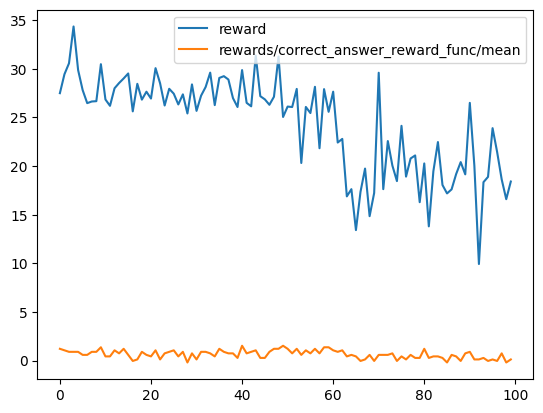

time: 153 ms (started: 2025-12-25 22:42:13 +00:00)


In [20]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

## View the results
Now let's try the model we just trained!

In [21]:
# Save the LoRA adapters
# No changes needed in this cell

# Save the LoRA model
model.save_pretrained("grpo_saved_lora")
tokenizer.save_pretrained("grpo_saved_lora")


('grpo_saved_lora/tokenizer_config.json',
 'grpo_saved_lora/special_tokens_map.json',
 'grpo_saved_lora/chat_template.jinja',
 'grpo_saved_lora/vocab.json',
 'grpo_saved_lora/merges.txt',
 'grpo_saved_lora/added_tokens.json',
 'grpo_saved_lora/tokenizer.json')

time: 2.93 s (started: 2025-12-25 22:42:13 +00:00)


In [22]:
# Create a function to run both the original model and the updated model
# No changes needed in this cell


"""def compare_old_and_new_model(messages):
    from vllm import SamplingParams

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    old = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
        )[0]
        .outputs[0]
        .text
    )

    new = (
        model.fast_generate(
            text,
            sampling_params=sampling_params,
            lora_request=model.load_lora("grpo_saved_lora"),
        )[0]
        .outputs[0]
        .text
    )

    print("===OLD===\n")
    print(old)

    print("\n\n===NEW===\n")
    print(new)"""

def compare_old_and_new_model(messages):
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Tokenize the input
    inputs = tokenizer([text], return_tensors="pt").to("cuda")

    # Generate with OLD (base) model - adapters disabled
    model.disable_adapter_layers()
    outputs_old = model.generate(
        **inputs,
        max_new_tokens=1024,
        temperature=0.8,
        top_p=0.95,
        do_sample=True,
    )
    old = tokenizer.decode(outputs_old[0], skip_special_tokens=True)

    # Generate with NEW (fine-tuned) model - adapters enabled
    model.enable_adapter_layers()
    outputs_new = model.generate(
        **inputs,
        max_new_tokens=1024,
        temperature=0.8,
        top_p=0.95,
        do_sample=True,
    )
    new = tokenizer.decode(outputs_new[0], skip_special_tokens=True)

    print("===OLD===\n")
    print(old)

    print("\n\n===NEW===\n")
    print(new)


time: 1.47 ms (started: 2025-12-25 22:42:16 +00:00)


### Compare the old and new models on the letter-counting task

In [23]:
# Let's try spelling the first word from the dataset
# TODO: Fill out the areas where you find **********

# Load the first item from the dataset (index 0) and compare the old and new models
# **********
"""text = tokenizer.apply_chat_template(
    ds[0]["prompt"], tokenize=False, add_generation_prompt=True
)

# Tokenize the input
inputs = tokenizer([text], return_tensors="pt").to("cuda")

# Generate using the fine-tuned model
outputs = model.generate(
    **inputs,
    max_new_tokens=200,
    temperature=0.8,
    top_p=0.95,
    do_sample=True,
)

# Decode the output
output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("=== PROMPT ===")
print(text)
print("\n=== FINE-TUNED MODEL OUTPUT ===")
print(output)"""

compare_old_and_new_model(ds[0]["prompt"])



===OLD===

system

Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>

user
How many of the letter "a" are there in the word "idea"
assistant
<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 1 so far
3. e - 2 so far
4. a - 3 so far
</reasoning>
<answer>
3
</answer>


===NEW===

system

Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>

user
How many of the letter "a" are there in the word "idea"
assistant
<reasoning>
Let's count the number of letter 'a' in the word 'idea'.
1. i - 0 so far 
2. d - 3 so far (i and

Our model is better at spelling and counter letters in words! Depending on your reward functions, the size of your model, and the amount of steps trained, results may vary.

For about an hour of training time, your model may not be perfect (or maybe it is), but it's definitely moving in the right direction!

### Make sure the model did not forget basic facts

In [24]:
# Let's see if the model still remembers some of the facts from its original training
# TODO: Fill out the areas where you find **********

# Ask both the old and new models a question the model is likely to know,
# e.g. a well-known capital city
# **********
question = "What is the capital of Spain?"

"""text = tokenizer.apply_chat_template(
    [{"role": "user", "content": question}],
    tokenize=False,
    add_generation_prompt=True
)

# Tokenize the input
inputs = tokenizer([text], return_tensors="pt").to("cuda")

# Generate using the fine-tuned model
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
)

# Decode the output
output = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("=== QUESTION ===")
print(question)
print("\n=== FINE-TUNED MODEL ANSWER ===")
print(output)"""

compare_old_and_new_model([{"role": "user", "content": question}])



===OLD===

system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
What is the capital of Spain?
assistant
The capital of Spain is Madrid.


===NEW===

system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
What is the capital of Spain?
assistant
The capital of Spain is Madrid.
time: 1.35 s (started: 2025-12-25 22:42:30 +00:00)


Great job! Congrats on completing the project! 🎉🤗